In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [3]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gc

%load_ext autoreload
%autoreload 2

from dataloader import get_data, get_data_3d
from sklearn.model_selection import train_test_split


In [4]:
labels = ['x', 'y'] #, 'z'] #, 'time', 'zenith', 'azimuth', 'dir_x', 'dir_y', 'dir_z', 'energy']
reco_labels = labels #[:-1]

Xs = []
ys = []
rs = []


for i in range(20):
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        X, y, r = get_data_3d(
            fname,
            labels = labels,
            reco_labels = reco_labels,
            N_events=None,
            min_pulses=10,
            )
        Xs.append(X)
        ys.append(y)
        rs.append(r)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

X_data = np.concatenate(Xs)
X_params = np.concatenate(ys)
r = np.concatenate(rs)
    
r = np.nan_to_num(r)
    
N_events, N_channels, N_features = X_data.shape
_, N_labels = X_params.shape



100%|██████████| 3031/3031 [00:04<00:00, 720.74it/s]


Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.120000.000010.hdf5


100%|██████████| 9368/9368 [00:28<00:00, 330.25it/s]


Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.120000.000100.hdf5


100%|██████████| 9233/9233 [00:24<00:00, 377.59it/s]


Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.120000.000180.hdf5


100%|██████████| 9413/9413 [00:24<00:00, 385.51it/s]


In [246]:
X_data_train, X_data_test, X_params_train, X_params_test, r_train, r_test = train_test_split(X_data, X_params, r, test_size=0.1, random_state=42)

In [458]:

activation='relu'


# Data network

inputs_data = tf.keras.Input(shape=(N_channels, N_features), )

h = tf.keras.layers.Reshape((86, 60 * N_features))(inputs_data)
h = tf.keras.layers.Dropout(0.01)(h)
ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * N_features,)), input_shape=(78, 60 * N_features))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * N_features,)), input_shape=(8, 60 * N_features))(dc)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(64,)), input_shape=(78,64))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(64,)), input_shape=(8,64))(h_dc)

h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)
h = tf.keras.layers.Dense(32, activation=activation)(h)
outputs_data = tf.keras.layers.Dense(32, activation=activation)(h)

model_data = tf.keras.Model(inputs=inputs_data, outputs=outputs_data)


# Parameters network

inputs_params = tf.keras.Input(shape=(N_labels,))

y = tf.keras.layers.Dense(32, activation=activation)(inputs_params)
y = tf.keras.layers.Dense(32, activation=activation)(y)
y = tf.keras.layers.Dense(32, activation=activation)(y)
y = tf.keras.layers.Dense(32, activation=activation)(y)
outputs_params = tf.keras.layers.Dense(32, activation=activation)(y)

model_params = tf.keras.Model(inputs=inputs_params, outputs=outputs_params)


combined = tf.keras.layers.Concatenate()([model_data.output, model_params.output])


z = tf.keras.layers.Dense(32, activation="relu")(combined)
z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(z)


# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[model_data.input, model_params.input], outputs=outputs)

model.summary()

loss_history = []
val_loss_history = []

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 5160, 7)]    0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 86, 420)      0           input_13[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 86, 420)      0           reshape_6[0][0]                  
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 78, 420)      0           dropout_28[0][0]                 
___________________________________________________________________________________________

In [459]:
#optimizer = tf.keras.optimizers.event_idx(0.001) #, clipnorm=1) # bad
#optimizer = tf.keras.optimizers.RMSprop(0.001, )
#optimizer = tf.keras.optimizers.Nadam(0.01)
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [60]:
del inputs_train
del outputs_train
del inputs_test
del outputs_test
gc.collect()

6298

In [61]:
inputs_train = [np.vstack([X_data_train, X_data_train]),  np.vstack([X_params_train, np.random.permutation(X_params_train)])]
outputs_train = np.concatenate([np.ones(X_data_train.shape[0]), np.zeros(X_data_train.shape[0])])
                
inputs_test = [np.vstack([X_data_test, X_data_test]),  np.vstack([X_params_test, np.random.permutation(X_params_test)])]
outputs_test = np.concatenate([np.ones(X_data_test.shape[0]), np.zeros(X_data_test.shape[0])])

In [ ]:
for i in range(5):
    # re-shuffle
    #inputs_train[1] = np.vstack([loss_historyarams_train, np.random.permutation(X_params_train)])
    #inputs_test[1] = np.vstack([X_params_test, np.random.permutation(X_params_test)])
    
    # sample from flat
    bounds = np.quantile(X_params, [0., 1.], axis=0)
    delta = np.diff(bounds, axis=0)
    
    rand_train_params = np.random.uniform(size=X_params_train.size).reshape(X_params_train.shape)
    rand_test_params = np.random.uniform(size=X_params_test.size).reshape(X_params_test.shape)
    
    rand_train_params *= delta
    rand_test_params *= delta
    
    rand_train_params += bounds[0]
    rand_test_params += bounds[0]
    
    inputs_train[1] = np.vstack([X_params_train, rand_train_params])
    inputs_test[1] = np.vstack([X_params_test, rand_test_params])
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    model.fit(inputs_train, outputs_train, batch_size=512, epochs=1, validation_data=(inputs_test, outputs_test))

    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])

Epoch 21
Train on 273712 samples, validate on 30414 samples
273712/273712 [==============================] - 14s 52us/sample - loss: 0.0398 - val_loss: 0.0413
Epoch 22
Train on 273712 samples, validate on 30414 samples
166912/273712 [=================>............] - ETA: 4s - loss: 0.0408

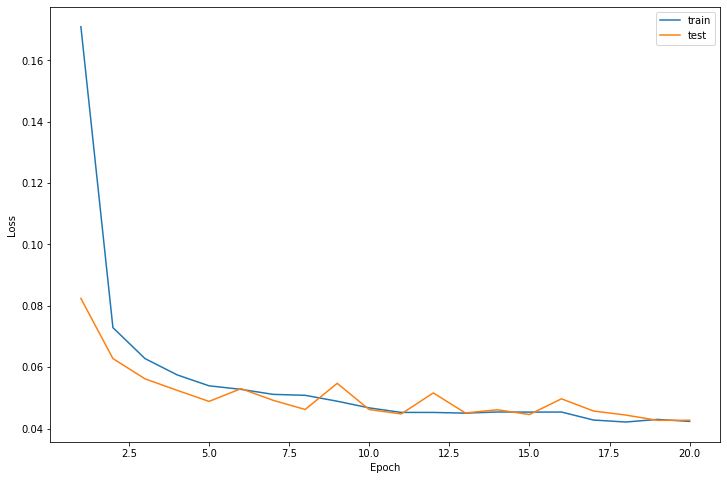

In [461]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
#ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [482]:
event_idx = -111

true_x = X_params_test[event_idx, 0]
true_y = X_params_test[event_idx, 1]

In [483]:
xs = np.linspace(true_x-100, true_x+100, 100)
ys = np.repeat(true_y, xs.shape[0])

params = np.stack([xs, ys]).T
data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

likelihood = model.predict([data, params], batch_size=512)


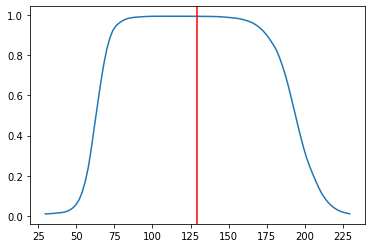

In [484]:
plt.plot(xs, likelihood)
plt.axvline(true_x, c='r')

In [485]:
N = 101
d = 100
xs = np.linspace(true_x-d, true_x+d, N)
ys = np.linspace(true_y-d, true_y+d, N)

xx, yy = np.meshgrid(xs,ys)

xx = xx.flatten()
yy = yy.flatten()

params = np.stack([xx, yy]).T
data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

likelihood = model.predict([data, params], batch_size=512)

z = likelihood.reshape((xs.shape[0], ys.shape[0]))

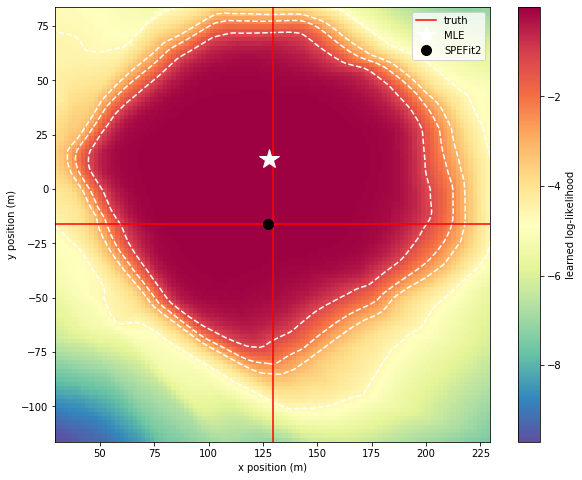

In [486]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

im = ax.imshow(np.log(z), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower', cmap='Spectral_r', aspect='equal')
ax.axvline(true_x, c='r')
ax.axhline(true_y, c='r', label='truth')

plt.colorbar(im, ax=ax, label='learned log-likelihood', )

plt.contour(xs, ys, np.log(z), [-9.21/2, -5.99/2, -4.51/2, -2.3/2], colors='w')

plt.plot(xx[np.argmax(z)],  yy[np.argmax(z)], marker='*', color='w', lw=0, ms=20, label='MLE')

plt.plot(r_test[event_idx][0],  r_test[event_idx][1], marker='o', color='k', lw=0, ms=10, label='SPEFit2')


ax.set_xlabel('x position (m)')
ax.set_ylabel('y position (m)')

plt.legend()

#plt.savefig('x-y_vertex_evnt%i.png'%event_idx, dpi=150)